# Analysis

In [83]:
%reset -f

# Genutzte Umgebung

In [84]:
import pandas as pd
from logger import Logger
from test_executer import TestExecutor
import extract
import sys
import numpy as np

logger = Logger()
testExecutor = TestExecutor(logger)

dependencies = [
    ('system', sys.version_info),
    ('pandas', pd.__version__),
    ('numpy', np.__version__),
]
for dependency in dependencies:
    logger.log(f"{dependency[0]} is installed with version {dependency[1]}")

{"type": "info", "time": 1657527286934, "message": "system is installed with version sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)", "params": null}
{"type": "info", "time": 1657527286934, "message": "pandas is installed with version 1.4.3", "params": null}
{"type": "info", "time": 1657527286934, "message": "numpy is installed with version 1.23.0", "params": null}


## Setup der Daten

Zuerst laden wir die benötigten Daten herunter und initialisieren die genutzten Python Objekte.

In [85]:
tables = [
    "careplans",
    "conditions",
    "observations",
    "patients",
]

files = [
    "data/others/",
    "data/asthma/",
    "data/gallstones/",
    "data/hypertension/",
]

In [86]:
!mkdir -p data/allergy

In [87]:
from urllib.request import urlopen
import os

def ensure_file_has_been_downloaded(filename):
    full_filename = "../" + filename

    url = "https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectC/main/" + filename
    if os.path.isfile(full_filename):
        logger.log("File {} already exists, skipping download".format(filename))
    else:
        logger.log("Downloading {}".format(filename))
        download_file(url, full_filename)

def download_file(url, filename):
    with open(filename, 'wb') as out_file:
        with urlopen(url) as file:
            out_file.write(file.read())

if not os.path.isfile("extract.py"):
    download_file(
        "https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectC/main/src/extract.py",
        "extract.py"
    )

for file in files:
    for table in tables:
        ensure_file_has_been_downloaded(file+table+".csv")

{"type": "info", "time": 1657527287158, "message": "File data/others/careplans.csv already exists, skipping download", "params": null}
{"type": "info", "time": 1657527287158, "message": "File data/others/conditions.csv already exists, skipping download", "params": null}
{"type": "info", "time": 1657527287158, "message": "File data/others/observations.csv already exists, skipping download", "params": null}
{"type": "info", "time": 1657527287158, "message": "File data/others/patients.csv already exists, skipping download", "params": null}
{"type": "info", "time": 1657527287158, "message": "File data/asthma/careplans.csv already exists, skipping download", "params": null}
{"type": "info", "time": 1657527287158, "message": "File data/asthma/conditions.csv already exists, skipping download", "params": null}
{"type": "info", "time": 1657527287158, "message": "File data/asthma/observations.csv already exists, skipping download", "params": null}
{"type": "info", "time": 1657527287159, "message

## Mit Datenbank verbinden

In [88]:
databaseFile = "data.sqlite"

logger.startTimeMeasurement('open-db', 'Connected to db and created tables')
connection = extract.connect_to_db(logger, databaseFile)  # create table patients, observations, conditions, careplans
logger.endTimeMeasurement('open-db')

In [89]:
def test_sqliteConnection(_logger):
    cursor = connection.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tablesInDb = list(map(lambda tableResult: tableResult[0], cursor.fetchall()))
    tablesInDb.sort()

    for table in tables:
        if not(table in tablesInDb):
            raise Exception('Table not found:', table)

testExecutor.execute('Test connection to database', test_sqliteConnection)

{"type": "info", "time": 1657527287218, "message": "✅ Test ran successfully: Test connection to database", "params": null}


## Daten in Datenbank laden

Lade der verwendete Daten in die Datenbank:

-   careplans
-   conditions
-   observations
-   patients

In [90]:
logger.startTimeMeasurement('load-data', 'Loading data into db')
for file in files:
    for table in tables:
        extract.insert_values_to_table(logger, connection.cursor(), table, "../"+ file + table + ".csv")  # TODO: insert ALL values in the right tables 
        connection.commit()

logger.endTimeMeasurement('load-data')

{"type": "info", "time": 1657527287240, "message": "🏗 Extracting data from ../data/others/careplans.csv", "params": null}
{"type": "info", "time": 1657527287247, "message": "🏗 Extracting data from ../data/others/conditions.csv", "params": null}
{"type": "info", "time": 1657527287265, "message": "🏗 Extracting data from ../data/others/observations.csv", "params": null}
{"type": "info", "time": 1657527287566, "message": "🏗 Extracting data from ../data/others/patients.csv", "params": null}
{"type": "info", "time": 1657527287572, "message": "🏗 Extracting data from ../data/asthma/careplans.csv", "params": null}
{"type": "info", "time": 1657527287583, "message": "🏗 Extracting data from ../data/asthma/conditions.csv", "params": null}
{"type": "info", "time": 1657527287708, "message": "🏗 Extracting data from ../data/asthma/observations.csv", "params": null}
{"type": "info", "time": 1657527288791, "message": "🏗 Extracting data from ../data/asthma/patients.csv", "params": null}
{"type": "info", "

## Messung der Datenfehler

Für unsere Forschungsfrage sind nur alle Daten mit gemessenen BMI relevant. Wurde dieser nicht vermessen oder eingetragen können die Daten für die Forschungsfrage nicht verwendet werden und sind somit unbrauchbar.

In [91]:
for table in tables:
    querie = f"SELECT * from {table};"
    df = pd.read_sql_query(querie,connection)
    result_string = str(df.isna().sum()).replace("\n"," NULL-Values in Column ")
    logger.log(f"Found {result_string} null-values in {table}.")
    print(df.isna().sum())


{"type": "info", "time": 1657527291340, "message": "Found Id                   0 NULL-Values in Column START                0 NULL-Values in Column STOP                 0 NULL-Values in Column PATIENT              0 NULL-Values in Column ENCOUNTER            0 NULL-Values in Column CODE                 0 NULL-Values in Column DESCRIPTION          0 NULL-Values in Column REASONCODE           0 NULL-Values in Column REASONDESCRIPTION    0 NULL-Values in Column dtype: int64 null-values in careplans.", "params": null}
Id                   0
START                0
STOP                 0
PATIENT              0
ENCOUNTER            0
CODE                 0
DESCRIPTION          0
REASONCODE           0
REASONDESCRIPTION    0
dtype: int64
{"type": "info", "time": 1657527291415, "message": "Found START          0 NULL-Values in Column STOP           0 NULL-Values in Column PATIENT        0 NULL-Values in Column ENCOUNTER      0 NULL-Values in Column CODE           0 NULL-Values in Column DESCRIP

In [92]:
all_patients_query = """
SELECT COUNT(id) FROM patients;"""
count_bmi_query = """
SELECT COUNT(distinct id) FROM patients JOIN observations on patients.id == observations.patient WHERE observations.Code = '59576-9'"""

count_all_bmi_query = f"""
SELECT COUNT(patient) FROM observations WHERE observations.Code = '59576-9'"""

patient_all_count = connection.execute(all_patients_query).fetchall()[0][0]
patient_bmi_count = connection.execute(count_bmi_query).fetchall()[0][0]
bmi_count = connection.execute(count_all_bmi_query).fetchall()[0][0]
ratio = round(patient_bmi_count/patient_all_count * 100, 3) 

logger.log(f"Total num of patients {patient_all_count}.")
logger.log(f"Found {patient_bmi_count} patients ({ratio}%) with {bmi_count} BMI-values.")

{"type": "info", "time": 1657527294049, "message": "Total num of patients 1326.", "params": null}
{"type": "info", "time": 1657527294049, "message": "Found 450 patients (33.937%) with 3539 BMI-values.", "params": null}


In [93]:
cursor = connection.cursor()

In [94]:
# print tables of the database
cursor.execute('SELECT name FROM sqlite_master where type="table"') 
print(cursor.fetchall())

[('patients',), ('careplans',), ('conditions',), ('observations',)]


# Star Schema

#### Erstellen Dimensionstabellen

Tabelle patients_

In [95]:
# table patients_
cursor.execute('''DROP TABLE IF EXISTS patients_;''')
cursor.execute('''
        CREATE TABLE patients_ ( 
        ID STRING PRIMARY KEY UNIQUE,
        RACE STRING, 
        ETHNICITY STRING,
        GENDER STRING,
        AGE INT64
        );''')

In [96]:
# create df patients
cursor.execute('''SELECT ID, BIRTHDATE, DEATHDATE, RACE, ETHNICITY, GENDER FROM PATIENTS;''')
df_patients = pd.DataFrame(cursor.fetchall(), columns=['ID', 'BIRTHDATE', 'DEATHDATE', 'RACE', 'ETHNICITY', 'GENDER'])

In [97]:
# convert to date
df_patients["DEATHDATE"] = pd.to_datetime(df_patients["DEATHDATE"])
df_patients["BIRTHDATE"] = pd.to_datetime(df_patients["BIRTHDATE"])
# fill null values withh todays date
df_patients['DEATHDATE'] = df_patients.DEATHDATE.fillna(pd.to_datetime("today"))
# calculate age
df_patients["AGE"] = df_patients.DEATHDATE.dt.year - df_patients.BIRTHDATE.dt.year
# drop unnecessary variables
df_patients = df_patients.drop(['BIRTHDATE', 'DEATHDATE'], axis=1)

In [98]:
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1326 non-null   object
 1   RACE       1326 non-null   object
 2   ETHNICITY  1326 non-null   object
 3   GENDER     1326 non-null   object
 4   AGE        1326 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 51.9+ KB


In [99]:
print("Number of Duplicated Rows", df_patients.duplicated(df_patients.columns).sum())

Number of Duplicated Rows 0


In [100]:
df_patients.to_sql('df_patients', connection, if_exists='replace', index=False)
cursor.execute('INSERT INTO patients_ (ID, RACE, ETHNICITY, GENDER, AGE) SELECT ID, RACE, ETHNICITY, GENDER, RACE FROM df_patients;')
cursor.execute('''DROP TABLE IF EXISTS df_patients;''')

print(pd.read_sql_query("PRAGMA table_info(patients_)", connection))

   cid       name    type  notnull dflt_value  pk
0    0         ID  STRING        0       None   1
1    1       RACE  STRING        0       None   0
2    2  ETHNICITY  STRING        0       None   0
3    3     GENDER  STRING        0       None   0
4    4        AGE   INT64        0       None   0


Tabelle observations_

In [101]:
# table observations_
cursor.execute('''DROP TABLE IF EXISTS observations_;''')
cursor.execute('''
        CREATE TABLE observations_ ( 
        CODE STRING PRIMARY KEY UNIQUE,
        DESCRIPTION STRING,
        UNITS STRING, 
        TYPE STRING
        );''')

# create df observation
cursor.execute('''SELECT CODE, DESCRIPTION, UNITS, TYPE FROM OBSERVATIONS;''')
df_observations = pd.DataFrame(cursor.fetchall(), columns=['CODE','DESCRIPTION', 'UNITS', 'TYPE'])

df_observations = df_observations.drop_duplicates(subset='CODE')

# transform dt in table
df_observations.to_sql('df_observations', connection, if_exists='replace', index=False)

cursor.execute('''INSERT INTO observations_ (CODE, DESCRIPTION, UNITS, TYPE) SELECT CODE, DESCRIPTION, UNITS, TYPE FROM df_observations;''')

cursor.execute('''DROP TABLE IF EXISTS df_observations;''')
print(pd.read_sql_query("PRAGMA table_info(observations_)", connection))
#print(pd.read_sql_query("SELECT * FROM observations_", connection))

   cid         name    type  notnull dflt_value  pk
0    0         CODE  STRING        0       None   1
1    1  DESCRIPTION  STRING        0       None   0
2    2        UNITS  STRING        0       None   0
3    3         TYPE  STRING        0       None   0


Tabelle careplans_code

In [102]:
# table careplans_code
cursor.execute('''DROP TABLE IF EXISTS careplans_code;''')
cursor.execute('''
        CREATE TABLE careplans_code ( 
        CODE STRING PRIMARY KEY UNIQUE,
        DESCRIPTION STRING
        );''')

# create df careplans_code
cursor.execute('''SELECT CODE, DESCRIPTION FROM CAREPLANS;''')
df_careplans_code = pd.DataFrame(cursor.fetchall(), columns=['CODE','DESCRIPTION'])

df_careplans_code = df_careplans_code.drop_duplicates(subset='CODE')

# transform dt in table
df_careplans_code.to_sql('df_careplans_code', connection, if_exists='replace', index=False)

cursor.execute('''INSERT INTO careplans_code (CODE, DESCRIPTION) SELECT CODE, DESCRIPTION FROM df_careplans_code;''')

cursor.execute('''DROP TABLE IF EXISTS df_careplans_code;''')
print(pd.read_sql_query("PRAGMA table_info(careplans_code)", connection))
#print(pd.read_sql_query("SELECT * FROM careplans_code", connection))

   cid         name    type  notnull dflt_value  pk
0    0         CODE  STRING        0       None   1
1    1  DESCRIPTION  STRING        0       None   0


Tabelle careplans_reasoncode

In [103]:
# table careplans_reasoncode
cursor.execute('''DROP TABLE IF EXISTS careplans_reasoncode;''')
cursor.execute('''
        CREATE TABLE careplans_reasoncode ( 
        REASONCODE STRING PRIMARY KEY UNIQUE,
        REASONDESCRIPTION STRING
        );''')

# create df careplans_code
cursor.execute('''SELECT REASONCODE, REASONDESCRIPTION FROM CAREPLANS;''')
df_careplans_reasoncode = pd.DataFrame(cursor.fetchall(), columns=['REASONCODE','REASONDESCRIPTION'])

df_careplans_reasoncode = df_careplans_reasoncode.drop_duplicates(subset='REASONCODE')

# transform dt in table
df_careplans_reasoncode.to_sql('df_careplans_reasoncode', connection, if_exists='replace', index=False)
   
cursor.execute('INSERT INTO careplans_reasoncode (REASONCODE, REASONDESCRIPTION) SELECT REASONCODE, REASONDESCRIPTION FROM df_careplans_reasoncode;')

cursor.execute('''DROP TABLE IF EXISTS df_careplans_reasoncode;''')
print(pd.read_sql_query("PRAGMA table_info(careplans_reasoncode)", connection))
#print(pd.read_sql_query("SELECT * FROM careplans_reasoncode", connection))

   cid               name    type  notnull dflt_value  pk
0    0         REASONCODE  STRING        0       None   1
1    1  REASONDESCRIPTION  STRING        0       None   0


Tabelle conditions_

In [104]:
# table conditions
cursor.execute('''DROP TABLE IF EXISTS conditions_;''')
cursor.execute('''
        CREATE TABLE conditions_ ( 
        CODE STRING PRIMARY KEY UNIQUE,
        DESCRIPTION STRING
        );''')

# create df conditions
cursor.execute('''SELECT CODE, DESCRIPTION FROM CONDITIONS;''')
df_conditions = pd.DataFrame(cursor.fetchall(), columns=['CODE','DESCRIPTION'])

df_conditions = df_conditions.drop_duplicates(subset='CODE')

# transform dt in table
df_conditions.to_sql('df_conditions', connection, if_exists='replace', index=False)

cursor.execute('INSERT INTO conditions_ (CODE, DESCRIPTION) SELECT CODE, DESCRIPTION FROM df_conditions;')

cursor.execute('''DROP TABLE IF EXISTS df_conditions;''')
print(pd.read_sql_query("PRAGMA table_info(conditions_)", connection))
#print(pd.read_sql_query("SELECT * FROM conditions_", connection))

   cid         name    type  notnull dflt_value  pk
0    0         CODE  STRING        0       None   1
1    1  DESCRIPTION  STRING        0       None   0


#### Erstelle Faktentabelle

In [105]:
cursor.execute('''DROP TABLE IF EXISTS fact_table;''')
cursor.execute('''
        CREATE TABLE fact_table ( 
        PATIENT_ID STRING,
        OBSERVATION_CODE STRING,
        VALUE STRING,
        DATE DATE,
        CONDITIONS_CODE STRING,
        ENDDATE DATE,
        CAREPLANS_CODE STRING,
        CAREPLANS_REASONCODE STRING,
        FOREIGN KEY (PATIENT_ID)
            REFERENCES patients_(ID),
        FOREIGN KEY (OBSERVATION_CODE)
            REFERENCES observations_(CODE),
        FOREIGN KEY (CONDITIONS_CODE)
            REFERENCES conditions_(CODE),
        FOREIGN KEY (CAREPLANS_CODE)
            REFERENCES careplans_code(CODE),
        FOREIGN KEY (CAREPLANS_REASONCODE)
            REFERENCES careplans_reasoncode(REASONCODE)
        );''')

cursor.execute('''INSERT INTO fact_table        
                    (PATIENT_ID, OBSERVATION_CODE, VALUE, DATE) 
                    SELECT PATIENT, CODE, VALUE, DATE 
                    FROM OBSERVATIONS
                    ;''')

cursor.execute('''INSERT INTO fact_table        
                    (PATIENT_ID, CAREPLANS_CODE, DATE, ENDDATE) 
                    SELECT PATIENT, CODE, START, STOP 
                    FROM CAREPLANS
                    ;''')

cursor.execute('''INSERT INTO fact_table        
                    (PATIENT_ID, CAREPLANS_REASONCODE, DATE, ENDDATE) 
                    SELECT PATIENT, REASONCODE, START, STOP 
                    FROM CAREPLANS
                    ;''')

cursor.execute('''INSERT INTO fact_table        
                    (PATIENT_ID, CONDITIONS_CODE, DATE, ENDDATE) 
                    SELECT PATIENT, CODE, START, STOP 
                    FROM CONDITIONS
                    ;''')

In [106]:
print(pd.read_sql_query("PRAGMA foreign_key_list(fact_table)", connection))

   id  seq                 table                  from          to  on_update  \
0   0    0  careplans_reasoncode  CAREPLANS_REASONCODE  REASONCODE  NO ACTION   
1   1    0        careplans_code        CAREPLANS_CODE        CODE  NO ACTION   
2   2    0           conditions_       CONDITIONS_CODE        CODE  NO ACTION   
3   3    0         observations_      OBSERVATION_CODE        CODE  NO ACTION   
4   4    0             patients_            PATIENT_ID          ID  NO ACTION   

   on_delete match  
0  NO ACTION  NONE  
1  NO ACTION  NONE  
2  NO ACTION  NONE  
3  NO ACTION  NONE  
4  NO ACTION  NONE  


In [107]:
cursor.execute('SELECT name FROM sqlite_master where type="table"')
print(cursor.fetchall())

[('patients',), ('careplans',), ('conditions',), ('observations',), ('patients_',), ('observations_',), ('careplans_code',), ('careplans_reasoncode',), ('conditions_',), ('fact_table',)]


## Analysis

Show the the percentile of a patient's body mass index indicates the relative position of the patient's BMI number among the given population. For children and teens the interpretation of BMI is both age- and sex-specific.

<AxesSubplot:>

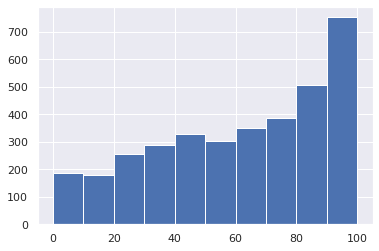

In [108]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

df_bmi_perc = pd.read_sql("SELECT * FROM fact_table WHERE observation_code = '59576-9'",connection)
df_bmi_perc['VALUE'].hist()

(array([9.970e+02, 1.315e+03, 1.060e+03, 2.255e+03, 8.941e+03, 3.000e+02,
        1.280e+02, 5.000e+01, 2.400e+01, 7.000e+00]),
 array([12.9 , 16.53, 20.16, 23.79, 27.42, 31.05, 34.68, 38.31, 41.94,
        45.57, 49.2 ]),
 <BarContainer object of 10 artists>)

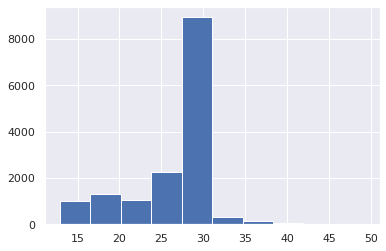

In [109]:
df_bmi = pd.read_sql("SELECT * FROM fact_table WHERE observation_code ='39156-5'",connection)
plt.hist(df_bmi['VALUE'])

In [110]:
df_height_weight = pd.read_sql("SELECT distinct fact_table.patient_id, fact_table.value,weight.value FROM fact_table left JOIN (SELECT distinct patient_ID,value FROM fact_table WHERE observation_code = '29463-7') AS weight on weight.patient_ID==fact_table.patient_id WHERE observation_code = '8302-2' ",connection)


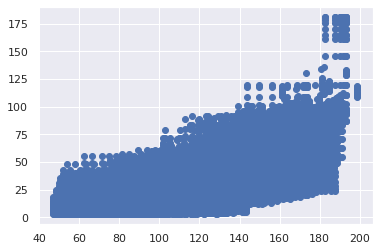

In [111]:
# TODO fix 
df_height_weight = pd.read_sql("SELECT distinct fact_table.patient_id, fact_table.value,weight.value FROM fact_table left JOIN (SELECT distinct patient_ID,value FROM fact_table WHERE observation_code = '29463-7') AS weight on weight.patient_ID==fact_table.patient_id WHERE observation_code = '8302-2' ",connection)
df_height_weight = df_height_weight.rename({'VALUE': 'height', 'value': 'weight'}, axis=1)
plt.scatter(df_height_weight.height,df_height_weight.weight)

[]

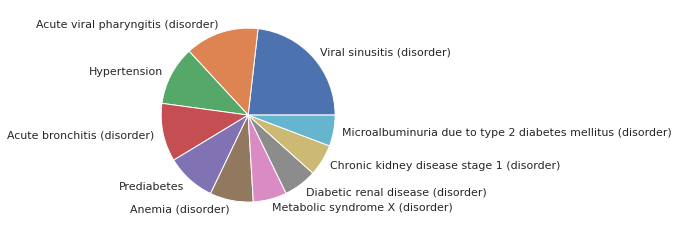

In [112]:
df_con = pd.read_sql("SELECT conditions.patient,conditions.code,conditions.description,observations.value\
 FROM conditions join observations on observations.patient==conditions.patient WHERE observations.Code = '39156-5' AND conditions.description NOT LIKE '%finding%'",connection)
plt.pie(df_con['DESCRIPTION'].value_counts()[:10],labels=df_con['DESCRIPTION'].value_counts()[:10].index)
plt.plot()

### Verteilung Oberservation/Conditions

Verschiedener Beobachtungen zu den Top 5 Krankheitesaufkommen in unseren Datensatz.



In [113]:
top_five = pd.DataFrame(df_con['DESCRIPTION'].value_counts()[:5]).reset_index()
top_five = top_five.rename({'index': 'DESCRIPTION', 'DESCRIPTION': 'COUNT'}, axis=1)
top_five['CODE'] = df_con['CODE'].value_counts()[:5].index
top_five

,DESCRIPTION,COUNT,CODE
0,Viral sinusitis (disorder),16761,444814009
1,Acute viral pharyngitis (disorder),9907,195662009
2,Hypertension,7931,59621000
3,Acute bronchitis (disorder),7820,10509002
4,Prediabetes,6679,15777000


- 8302-2,Body Height
- 29463-7,Body Weight
- 39156-5,Body Mass Index
- 8462-4,Diastolic Blood Pressure
- 8480-6,Systolic Blood Pressure
- 8867-4,Heart rate

In [114]:
disease_labels = ['Viral sinusitis (disorder)','Acute viral pharyngitis (disorder)','Hypertension','Acute bronchitis (disorder)','Prediabetes']
disease_codes = [444814009,195662009,59621000,10509002,15777000]
observation_lables = ['Body Height','Body Weight','Body Mass Index','Diastolic Blood Pressure','Systolic Blood Pressure','Heart rate']
observation_codes = ['8302-2','29463-7','39156-5','8462-4','8480-6','8867-4']
df_lists = list()
for dis_code,dis_lable in zip(disease_codes,disease_labels):
    df = pd.DataFrame()
    for ob_code,ob_lable in zip(observation_codes,observation_lables):
        sql_pattern = f"""
        SELECT observations.date,conditions.patient,conditions.code,observations.value
            FROM conditions join observations on observations.patient==conditions.patient
            WHERE observations.Code = '{ob_code}' AND conditions.code = '{dis_code}'"""
        df[ob_lable] = pd.read_sql(sql_pattern,connection)['VALUE']
    df['Disease'] = dis_lable
    df_lists.append(df)
df_data = pd.concat(df_lists).reset_index(drop=True)
df_data.head()

,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Disease
0,52.6,2.9,28.5,71.0,123.0,68.0,Viral sinusitis (disorder)
1,57.7,3.6,29.7,72.0,126.0,90.0,Viral sinusitis (disorder)
2,61.5,4.8,27.7,69.0,118.0,99.0,Viral sinusitis (disorder)
3,66.1,5.8,27.6,65.0,130.0,73.0,Viral sinusitis (disorder)
4,69.9,7.0,27.6,69.0,125.0,74.0,Viral sinusitis (disorder)


In [115]:
df_data['class'] = ''
df_data.loc[df_data['Body Mass Index'].values<18,'class'] = 'underweight'
df_data.loc[df_data['Body Mass Index'].values>=18,'class'] = 'normal'
df_data.loc[df_data['Body Mass Index'].values>=25,'class'] = 'overweight'
df_data.loc[df_data['Body Mass Index'].values>=30,'class'] = 'obese'
df_data.head()

,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Disease,class
0,52.6,2.9,28.5,71.0,123.0,68.0,Viral sinusitis (disorder),overweight
1,57.7,3.6,29.7,72.0,126.0,90.0,Viral sinusitis (disorder),overweight
2,61.5,4.8,27.7,69.0,118.0,99.0,Viral sinusitis (disorder),overweight
3,66.1,5.8,27.6,65.0,130.0,73.0,Viral sinusitis (disorder),overweight
4,69.9,7.0,27.6,69.0,125.0,74.0,Viral sinusitis (disorder),overweight


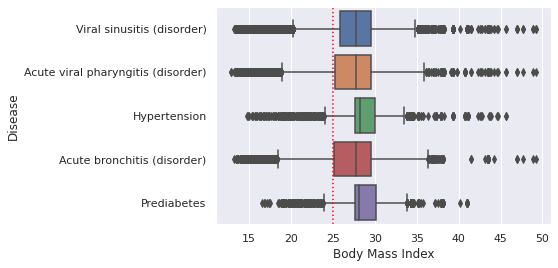

In [116]:
sns.set(style="darkgrid")
ax = sns.boxplot(x="Body Mass Index", y="Disease", data=df_data)
plt.axvline(x=25, c='red',ls=':')
plt.show()

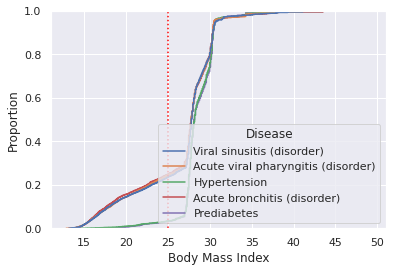

In [117]:
ax = sns.ecdfplot(data=df_data, x="Body Mass Index",hue='Disease')
plt.axvline(x=25, c='red',ls=':')
plt.show()

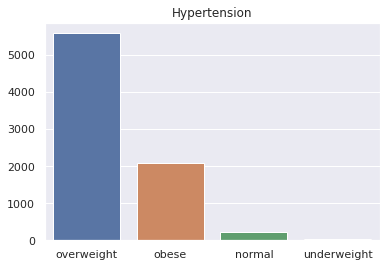

In [118]:
df_hypertension = df_data.where(df_data['Disease']== 'Hypertension')
sns.barplot(x=df_hypertension['class'].value_counts().index,y=df_hypertension['class'].value_counts().values)
plt.title("Hypertension")
plt.show()

### [Regression](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py)

In [119]:
from sklearn.linear_model import LogisticRegression

df_reg = df_data.dropna()
X, y = df_reg.drop(['Disease','class'],axis=1)['Body Mass Index'].values.reshape((-1, 1)), df_reg['Disease']
model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X,y)

model.predict(np.array([25,]).reshape(-1, 1))

array(['Viral sinusitis (disorder)'], dtype=object)

### [Decision tree](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

In [120]:
from sklearn import tree
df_tree = df_data.dropna()
X, y = df_tree.drop(['Disease','class'],axis=1), df_tree['Disease']
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

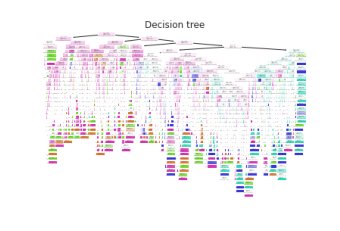

In [121]:
from sklearn.tree import plot_tree
import matplotlib.image as mpimg


plt.figure()

# need to munch time to run in CI
# plot_tree(clf, filled=True)
# plt.savefig('../images/decision_tree.png')
# plt.title("Decision tree")

img = mpimg.imread('../images/decision_tree.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Aufräumen & Logs speichern

In [122]:
connection.close()
logger.logTimings()
logger.writeToFile("../artefacts-for-release/analysis-log.json")

{"type": "info", "time": 1657527300570, "message": "⏳ Connected to db and created tables in 106490ms", "params": {"timingInMilliseconds": 106490}}
{"type": "info", "time": 1657527300570, "message": "⏳ Loading data into db in 110528ms", "params": {"timingInMilliseconds": 110528}}


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'